# Bayesian Optimization Case Study

## Introduction

In this case study, we will explore how to use Bayesian Optimization to tune the hyperparameters of a machine learning model. Bayesian Optimization is a powerful technique for optimizing expensive black-box functions, such as the validation performance of a complex model. 

Bayesian Optimization works by constructing a probabilistic model of the objective function and using it to guide the search for the optimal hyperparameter values. This approach is particularly useful when the objective function (e.g., the model's validation performance) is computationally expensive to evaluate, as Bayesian Optimization can find the optimum with fewer function evaluations compared to other optimization methods.

## Objectives

In this case study, we will be using the LightGBM library to build a binary classification model on a real-world dataset related to flight delays. Our goal is to find the best hyperparameter settings that maximize the model's AUC (Area Under the Receiver Operating Characteristic Curve) score using Bayesian Optimization.

The hyperparameters we will be optimizing include:

- `num_leaves`: The number of leaves in each tree
- `max_depth`: The maximum depth of each tree
- `lambda_l2`: L2 regularization term on weights
- `lambda_l1`: L1 regularization term on weights
- `min_child_samples`: The minimum number of data points needed in a leaf
- `min_data_in_leaf`: The minimum number of data points allowed in a leaf
- `learning_rate`: The step size at each iteration while moving toward a minimum of a loss function.
- `subsample_freq`: The frequency for bagging.

By leveraging Bayesian Optimization, we aim to identify the optimal configuration of these hyperparameters that maximizes the model's predictive performance, as measured by the AUC metric. This will help us build a more accurate flight delay prediction model, which can be valuable for airlines, passengers, and other stakeholders.



## Setup

First, let's import the necessary libraries and load the data:

In [92]:
import warnings
import numpy as np
import pandas as pd
import lightgbm as lgb
from bayes_opt import BayesianOptimization
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve, accuracy_score, roc_auc_score
from sklearn.metrics import average_precision_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

In [70]:
df_flights = pd.read_csv('flight_delays_train.csv')
df_flights.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [71]:
df_flights.describe()

,DepTime,Distance
count,100000.000000,100000.00000
mean,1341.523880,729.39716
std,476.378445,574.61686
min,1.000000,30.00000
25%,931.000000,317.00000
50%,1330.000000,575.00000
75%,1733.000000,957.00000
max,2534.000000,4962.00000


## Feature Engineering

The feature engineering process involves creating new features and transforming existing ones to better capture the underlying patterns in the data, aiming to improve model performance. The steps include:

- **Combining Columns**: New identifiers are created by concatenating `Origin` and `Dest` into `flight`, and similarly for `flightUC`, `DestUC`, and `OriginUC` with `UniqueCarrier`.
- **Extracting Date Parts**: Numerical parts are extracted from `Month`, `DayofMonth`, and `DayOfWeek`, and categorized into beginning, middle, or end of the month, and into seasons.
- **Time Transformations**: `DepTime` is converted into `hour`, and further into parts of the day (`morning`, `day`, `evening`, `night`), and harmonic features (`deptime_cos`, `deptime_sin`) to capture cyclical nature.
- **Categorical to Numerical**: Categorical variables like `UniqueCarrier`, `Origin`, and `Dest` are encoded numerically.
- **Aggregations**: Counts per month and overall for airports (`Dest`, `Origin`) and carriers are calculated to capture frequency information.
- **Dropping Unused Columns**: Columns like `DepTime` are dropped after extracting relevant features.

The `label_enc` function applies label encoding to a given DataFrame column, converting categorical variables into numerical representations.

The `make_harmonic_features_sin` and `make_harmonic_features_cos` functions create sine and cosine features based on the `DepTime` column, which can help capture periodic patterns in the data.

The `feature_eng` function performs the feature engineering steps described above, creating new columns and transforming existing ones to enrich the dataset for the predictive model.


In [73]:
def label_enc(df_column):
    df_column = LabelEncoder().fit_transform(df_column)
    return df_column

def make_harmonic_features_sin(value, period=2400):
    value *= 2 * np.pi / period 
    return np.sin(value)

def make_harmonic_features_cos(value, period=2400):
    value *= 2 * np.pi / period 
    return np.cos(value)

def feature_eng(df):
    df['flight'] = df['Origin']+df['Dest']
    df['Month'] = df.Month.map(lambda x: x.split('-')[-1]).astype('int32')
    df['DayofMonth'] = df.DayofMonth.map(lambda x: x.split('-')[-1]).astype('uint8')
    df['begin_of_month'] = (df['DayofMonth'] < 10).astype('uint8')
    df['midddle_of_month'] = ((df['DayofMonth'] >= 10)&(df['DayofMonth'] < 20)).astype('uint8')
    df['end_of_month'] = (df['DayofMonth'] >= 20).astype('uint8')
    df['DayOfWeek'] = df.DayOfWeek.map(lambda x: x.split('-')[-1]).astype('uint8')
    df['hour'] = df.DepTime.map(lambda x: x/100).astype('int32')
    df['morning'] = df['hour'].map(lambda x: 1 if (x <= 11)& (x >= 7) else 0).astype('uint8')
    df['day'] = df['hour'].map(lambda x: 1 if (x >= 12) & (x <= 18) else 0).astype('uint8')
    df['evening'] = df['hour'].map(lambda x: 1 if (x >= 19) & (x <= 23) else 0).astype('uint8')
    df['night'] = df['hour'].map(lambda x: 1 if (x >= 0) & (x <= 6) else 0).astype('int32')
    df['winter'] = df['Month'].map(lambda x: x in [12, 1, 2]).astype('int32')
    df['spring'] = df['Month'].map(lambda x: x in [3, 4, 5]).astype('int32')
    df['summer'] = df['Month'].map(lambda x: x in [6, 7, 8]).astype('int32')
    df['autumn'] = df['Month'].map(lambda x: x in [9, 10, 11]).astype('int32')
    df['holiday'] = (df['DayOfWeek'] >= 5).astype(int) 
    df['weekday'] = (df['DayOfWeek'] < 5).astype(int)
    df['airport_dest_per_month'] = df.groupby(['Dest', 'Month'])['Dest'].transform('count')
    df['airport_origin_per_month'] = df.groupby(['Origin', 'Month'])['Origin'].transform('count')
    df['airport_dest_count'] = df.groupby(['Dest'])['Dest'].transform('count')
    df['airport_origin_count'] = df.groupby(['Origin'])['Origin'].transform('count')
    df['carrier_count'] = df.groupby(['UniqueCarrier'])['Dest'].transform('count')
    df['carrier_count_per month'] = df.groupby(['UniqueCarrier', 'Month'])['Dest'].transform('count')
    df['deptime_cos'] = df['DepTime'].map(make_harmonic_features_cos)
    df['deptime_sin'] = df['DepTime'].map(make_harmonic_features_sin)
    df['flightUC'] = df['flight']+df['UniqueCarrier']
    df['DestUC'] = df['Dest']+df['UniqueCarrier']
    df['OriginUC'] = df['Origin']+df['UniqueCarrier']
    return df.drop('DepTime', axis=1)

In [74]:
# Split the dataset into features (X) and target (y):
X = df_flights.drop('dep_delayed_15min', axis=1)
y = df_flights['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Apply feature engineering
X_train = feature_eng(X_train)
X_val = feature_eng(X_val)
X_test = feature_eng(X_test)

# Create a list of the categorical features
categorical_features = ['Month', 'DayOfWeek', 'UniqueCarrier', 'Origin', 'Dest', 'flight', 'flightUC', 'DestUC', 'OriginUC']

# Encode categorical features
for column in categorical_features:
    X_train[column] = label_enc(X_train[column])
    X_val[column] = label_enc(X_val[column])
    X_test[column] = label_enc(X_test[column])

## LightGBM
The `lgb` library refers to LightGBM, a gradient boosting framework that uses tree-based learning algorithms. It is designed for speed and efficiency, suitable for large datasets.

The `lgb_eval` function is designed to evaluate a LightGBM model with specified hyperparameters using cross-validation. It returns the mean AUC (Area Under the ROC Curve) score from the last iteration of the cross-validation process, which serves as a performance metric for binary classification tasks.

### Parameters:
- `num_leaves`: The number of leaves in each tree. More leaves can increase model complexity.
- `max_depth`: The maximum depth of each tree. A deeper tree can express more complex relationships.
- `lambda_l2`: L2 regularization term on weights, used to avoid overfitting.
- `lambda_l1`: L1 regularization term on weights, also used to prevent overfitting.
- `min_child_samples`: The minimum number of data points needed in a leaf.
- `min_data_in_leaf`: The minimum number of data points allowed in a leaf. This can be used to deal with over-fitting.
- `learning_rate`: The step size at each iteration while moving toward a minimum of a loss function.
- `subsample_freq`: The frequency for bagging.
- `bagging_seed`: Random seed for bagging.
- `verbosity`: The level of verbosity of the process (e.g., -1 for no output).

### Usage:
This function is used for hyperparameter tuning in the context of a Bayesian optimization process. By evaluating the model's performance with different sets of hyperparameters, one can identify the optimal configuration that maximizes the AUC score.

In [108]:
def lgb_eval(num_leaves, max_depth, lambda_l2, lambda_l1, min_child_samples, 
             min_data_in_leaf, learning_rate, subsample_freq):
    """Evaluate LightGBM model with given hyperparameters using cross-validation."""
    params = {
        "objective": "binary",
        "metric": "auc",
        'is_unbalance': True,
        "num_leaves": int(num_leaves),
        "max_depth": int(max_depth),
        "lambda_l2": lambda_l2,
        "lambda_l1": lambda_l1,
        "num_threads": 20,
        "min_child_samples": int(min_child_samples),
        'min_data_in_leaf': int(min_data_in_leaf),
        "learning_rate": learning_rate,
        "subsample_freq": int(subsample_freq),
        "bagging_seed": 42,
        "verbosity": -1
    }

    lgtrain = lgb.Dataset(X_train, y_train, categorical_feature=categorical_features)

    early_stopping_callback = lgb.early_stopping(100, verbose=False)  # Stops if no improvement after 100 rounds

    cv_result = lgb.cv(params,
                       lgtrain,
                       num_boost_round=1000,
                       nfold=3,
                       stratified=True,
                       seed=42,
                       callbacks=[early_stopping_callback])
    
    return cv_result['valid auc-mean'][-1]

Next we'll apply the Bayesian optimizer to the function we created in the previous step to identify the best hyperparameters. We will run 10 iterations and set init_points = 2.


In [109]:
# Setup for Bayesian Optimization
lgbBO = BayesianOptimization(lgb_eval, {
    'num_leaves': (25, 4000),
    'max_depth': (5, 63),
    'lambda_l2': (0.0, 0.05),
    'lambda_l1': (0.0, 0.05),
    'min_child_samples': (50, 10000),
    'min_data_in_leaf': (100, 2000),
    'learning_rate': (0.001, 0.5),
    'subsample_freq': (0, 10)
})

lgbBO.maximize(n_iter=10, init_points=2)

|   iter    |  target   | lambda_l1 | lambda_l2 | learni... | max_depth | min_ch... | min_da... | num_le... | subsam... |
-------------------------------------------------------------------------------------------------------------------------
| 1         | 0.7219    | 0.04353   | 0.02314   | 0.4293    | 26.45     | 4.742e+03 | 1.685e+03 | 2.373e+03 | 1.056     |
| 2         | 0.6974    | 0.005624  | 0.009483  | 0.4349    | 9.227     | 461.4     | 226.0     | 3.96e+03  | 0.7716    |
| 3         | 0.7236    | 0.007683  | 0.01435   | 0.1347    | 40.71     | 3.028e+03 | 1.096e+03 | 3.583e+03 | 8.604     |
| 4         | 0.7047    | 0.007689  | 0.03936   | 0.3152    | 39.99     | 5.792e+03 | 629.0     | 689.9     | 6.791     |
| 5         | 0.7194    | 0.008136  | 0.03009   | 0.4189    | 56.57     | 3.841e+03 | 1.36e+03  | 3e+03     | 6.961     |
| 6         | 0.7174    | 0.02685   | 0.01266   | 0.02253   | 38.18     | 2.519e+03 | 725.9     | 512.2     | 0.001552  |
| 7         | 0.7325    

In [110]:
# Print the best hyperparameters
print("Optimal Hyperparameters:")
for param, value in lgbBO.max['params'].items():
    print(f"{param}: {value}")

Optimal Hyperparameters:
lambda_l1: 0.044409004504972954
lambda_l2: 0.005198158333783138
learning_rate: 0.06631732831690465
max_depth: 28.94825697867784
min_child_samples: 5704.951018541504
min_data_in_leaf: 1458.7000587938464
num_leaves: 433.9353462469904
subsample_freq: 3.642098929648807


## Train the Final LightGBM Model: 

Train the final LightGBM model with optimal hyperparameters.

### Inputs:
- `num_leaves`, `max_depth`, `lambda_l2`, `lambda_l1`, `min_child_samples`, `min_data_in_leaf`: Optimal hyperparameters from Bayesian Optimization
- `X_train`, `y_train`: Training data (features and target variable)
- `X_val`, `y_val`: Validation data (features and target variable)

## Steps:
1. Define LightGBM model parameters with optimal hyperparameters
2. Create LightGBM datasets for train and validation
3. Set up early stopping callback
4. Train the model with early stopping on validation set
5. Return the trained model

In [111]:
def lgb_train(X_train, y_train, X_val, y_val, num_leaves, max_depth, lambda_l2, 
              lambda_l1, min_child_samples, min_data_in_leaf, learning_rate, subsample_freq):
    """Train the final LightGBM model with the given hyperparameters and datasets."""
    # Define LightGBM model parameters with optimal hyperparameters
    params = {
        "objective": "binary",
        "metric": "auc",
        "is_unbalance": True,
        "num_leaves": int(num_leaves),
        "max_depth": int(max_depth),
        "lambda_l2": lambda_l2,
        "lambda_l1": lambda_l1,
        "num_threads": 20,
        "min_child_samples": int(min_child_samples),
        "min_data_in_leaf": int(min_data_in_leaf),
        "learning_rate": learning_rate,  # Use the learning_rate parameter
        "subsample_freq": int(subsample_freq),  # Use the subsample_freq parameter
        "bagging_seed": 42,
        "verbosity": -1
    }

    # Create LightGBM datasets for train and validation
    lgtrain = lgb.Dataset(X_train, y_train, categorical_feature=categorical_features)
    lgval = lgb.Dataset(X_val, y_val, reference=lgtrain)

    # Set up early stopping callback
    early_stopping_callback = lgb.early_stopping(100, verbose=False)

    # Train the model with early stopping on validation set
    eval_results = {}
    model = lgb.train(params,
                      lgtrain,
                      num_boost_round=10000,
                      valid_sets=[lgtrain, lgval],
                      valid_names=['train', 'valid'],
                      callbacks=[early_stopping_callback, lgb.record_evaluation(eval_results)])

    # Get the validation AUC
    val_auc = eval_results['valid']['auc'][-1]

    # Return the trained model, validation AUC, and eval_results
    return model, val_auc, eval_results

<Figure size 800x600 with 0 Axes>

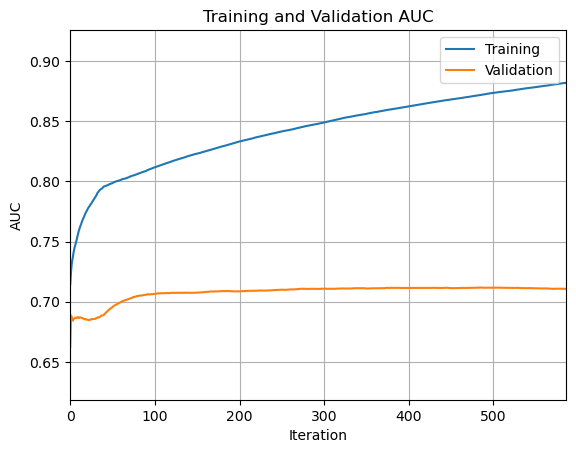

In [112]:
# Call the training function with the training/validation sets & optimal hyperparameters
final_model, val_auc, eval_results = lgb_train(
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    num_leaves=lgbBO.max['params']['num_leaves'],
    max_depth=lgbBO.max['params']['max_depth'],
    lambda_l2=lgbBO.max['params']['lambda_l2'],
    lambda_l1=lgbBO.max['params']['lambda_l1'],
    min_child_samples=lgbBO.max['params']['min_child_samples'],
    min_data_in_leaf=lgbBO.max['params']['min_data_in_leaf'],
    learning_rate=lgbBO.max['params']['learning_rate'],
    subsample_freq=lgbBO.max['params']['subsample_freq']
)

plt.figure(figsize=(8, 6))
lgb.plot_metric(eval_results, metric='auc')
plt.title('Training and Validation AUC')
plt.xlabel('Iteration')
plt.ylabel('AUC')
plt.legend(['Training', 'Validation'])
plt.show()

In [118]:
# Evaluate model performance on X_test and y_test
y_pred = final_model.predict(X_test)
y_pred_binary = [1 if x > 0.5 else 0 for x in y_pred]

final_model_accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Final Model Accuracy: {final_model_accuracy:.4f}")
print("AUC:", roc_auc_score(y_test, y_pred))

Final Model Accuracy: 0.7816
AUC: 0.7142561366805819


## Plot the ROC curve and calculate the area under the curve (AUC)

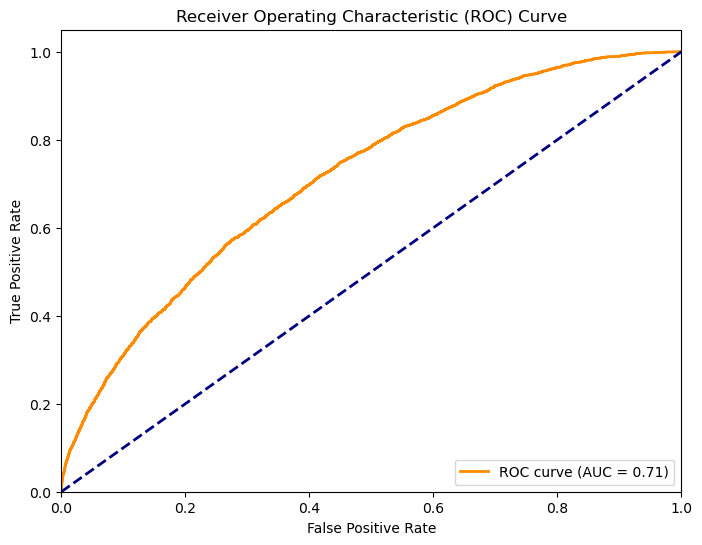

In [115]:
# Calculate the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calculate the AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

An AUC of 0.71 indicates that the model has a moderate discriminative power. This means that the model is able to distinguish between the positive and negative classes to a reasonable extent, but there is still room for improvement.

## Plot the precision-recall curve

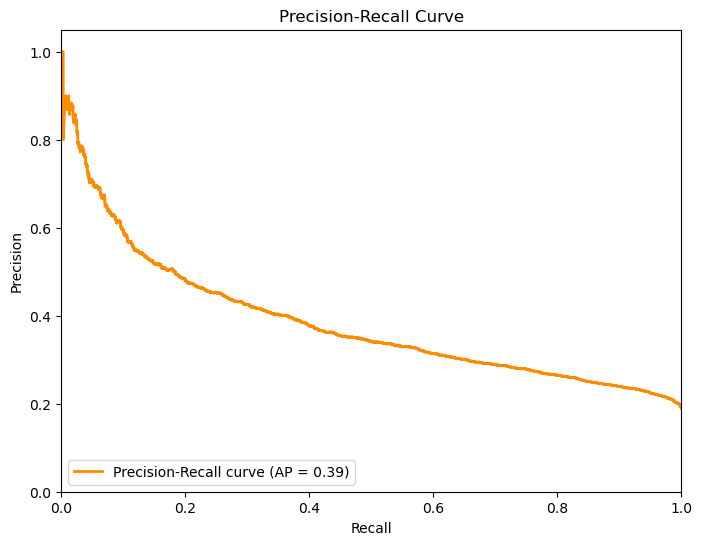

In [116]:
# Calculate the precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

# Calculate the average precision
avg_precision = average_precision_score(y_test, y_pred)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='darkorange', lw=2, label=f'Precision-Recall curve (AP = {avg_precision:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

The Average Precision (AP) is a measure that combines precision and recall into a single metric. It is particularly useful for imbalanced datasets, where accuracy can be misleading.

An AP of 0.39 suggests that the model is not performing as well as it could in terms of balancing precision and recall. This could indicate that the model is either overfitting, underfitting, or struggling to handle the class imbalance in the data.

<Figure size 800x600 with 0 Axes>

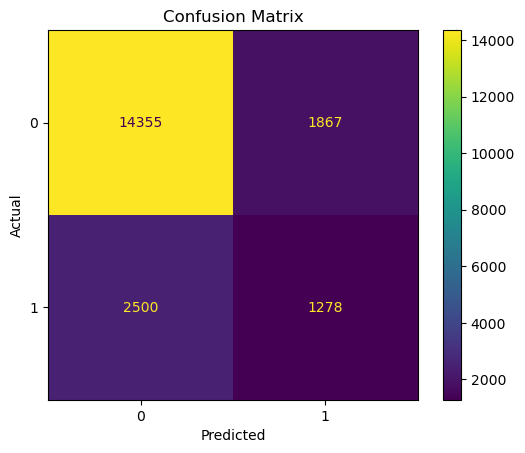

In [117]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [119]:
# Calculate majority class baseline for comparison
y_test_mean = y_test.mean()
majority_class = 1 if y_test_mean > 0.5 else 0
y_pred_majority = [majority_class] * len(y_test)
majority_accuracy = accuracy_score(y_test, y_pred_majority)
print(f"Majority Class Baseline Accuracy: {majority_accuracy:.4f}")

Majority Class Baseline Accuracy: 0.8111
